In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import vuong_tests

In [2]:
beta0 = 5
beta1 = 3.

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=-2,scale=1,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(1000,)
(1000, 2)
ModeResult(mode=array([0.]), count=array([612]))


In [3]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args, error_distr=stats.norm, **kwargs):
        self.error_distr = error_distr
        super(Tobit,self).__init__(*args,**kwargs)
        self._set_extra_params_names(['var'])
        self.start_params = np.array([1]*(self.exog.shape[1]+1))
        
        #print(self.error_distr)
        #print(error_distr)
        #self.start_params = np.array( range(1, (2*self.exog.shape[1]+2)))
        #2 sets of params for z, 1 for x, 2 variances...
    
    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        
        mu_y = np.matmul(x,beta)
        
        pr_y = self.error_distr.logpdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        pr_m = self.error_distr.logcdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        ll =  (1-m)*pr_y + m*pr_m
        return ll
    
    def score(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        m_x = np.repeat(m,x.shape[1]).reshape(x.shape)
        
        b = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        s =  np.sqrt(sigma2)

        beta_jac = np.zeros(len(b))
        sigma_jac = 0
        
        #for censored
        left_stats = (y - np.dot(x, b)) / s
        l_pdf = scipy.stats.norm.logpdf(left_stats)
        l_cdf = scipy.stats.norm.logcdf(left_stats)
        left_frac = np.exp(l_pdf - l_cdf)
        beta_left = np.dot(left_frac*m, x*m_x / s)
        beta_jac -= beta_left
        left_sigma = np.dot(left_frac*m, left_stats*m)
        sigma_jac -= left_sigma
        
        #for non-censored
        mid_stats = (y - np.dot(x, b)) / s
        beta_mid = np.dot(mid_stats*(1-m), x*(1-m_x) / s)
        beta_jac += beta_mid
        mid_sigma = ((np.square(mid_stats) - 1)*(1-m)).sum()
        sigma_jac += mid_sigma
        
        combo_jac = np.append(beta_jac, sigma_jac / (2*s) )  # by chain rule, since the expression above is dloglik/dlogsigma
        return combo_jac


model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Tobit Results                                 
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -651.61
Model:                          Tobit   AIC:                             1307.
Method:            Maximum Likelihood   BIC:                             1317.
Date:                Tue, 01 Dec 2020                                         
Time:                        15:59:31                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0332      0.093     54.184      0.000       4.851       5.215
x1             3.0005      0.069     43.504      0.000       2.865       3.136
var            0.9361      0.067     13.975      0.000       0.805       1.067
==============================================================================
"""

In [4]:
def compute_llr(yn,xn):
    
    #fit normal values
    model1 = Tobit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    
    #fit logistic values
    model2 = Tobit(yn,sm.add_constant(xn),error_distr=stats.logistic)
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    
    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)

yn,xn,nobs = gen_data()
print(compute_llr(yn,xn))

(5.918844650241908, 0.06882728262493905)


boot 2.6600684829294536 0.12432551934775837 4.769766020916964 

1
1


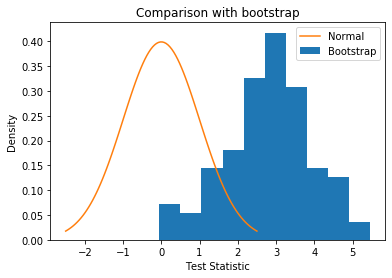

In [5]:
yn,xn,nobs = gen_data()
print(vuong_tests.bootstrap_test(yn,xn,nobs,compute_llr,hist=True))
print(vuong_tests.regular_test(yn,xn,nobs,compute_llr,hist=True))

plt.title("Comparison with bootstrap")
plt.xlabel("Test Statistic")
plt.ylabel("Density")
plt.legend()
plt.savefig('../figs/bootstrap_compare_tobit2')
plt.show()

In [6]:
reg,boot,llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr)
print("reg: %s, boot: %s, llr:%s, omega:%s"%(reg,boot,llr, omega))

reg: [0.63 0.37 0.  ], boot: [0.76 0.24 0.  ], llr:4.048412161933539, omega:0.07640743005114001


In [6]:
def setup_shi(yn,xn):
    model1 = Tobit(yn,sm.add_constant(xn))
    model1_fit = model1.fit( disp=False)
    k1 = len(model1_fit.params)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    
    #fit logistic values
    model2 = Tobit(yn,sm.add_constant(xn),error_distr=stats.logistic)
    model2_fit = model2.fit(disp=False)
    k2 = len(model2_fit.params)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
print(grad1.shape)

(1000, 3)


In [16]:
shi_result = vuong_tests.monte_carlo_shi(300,setup_shi,gen_data)
print(shi_result)

[0.66 0.34 0.  ]


In [9]:
#reg: [0.63 0.37 0.  ], boot: [0.76 0.24 0.  ], llr:4.048412161933539, omega:0.07640743005114001

In [ ]:
#[0.66 0.34 0.  ]